In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from src.utils.datasets.ggimages import OpenImage
from src.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose, XyToCenter
import torchvision.transforms as transforms
from src.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from src.utils.datasets.adapter import convert_data
import numpy as np
from src.network.yolo import Yolo
from src.config import VOC_ANCHORS
from src.utils.process_boxes import preprocess_true_boxes
from src.config import IOU_THRESHOLD, TENSORBOARD_PATH
from tensorboardX import SummaryWriter
from datetime import datetime
import time
from PIL import Image
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [3]:
general_transform = Compose([
    Resize((448, 448)),
    RandomHorizontalFlip(0.3),
    XyToCenter()
])


transform = transforms.Compose([
                transforms.RandomChoice([
                    transforms.ColorJitter(hue=.3, saturation=.2),
                    transforms.RandomGrayscale(p=0.3),
                ]),
                transforms.ToTensor()
            ])


val_general_transform = Compose([
    Resize((448, 448)),
    XyToCenter()
])


val_transform = transforms.Compose([
                transforms.ToTensor()
            ])

In [4]:
batch_size = 48

ds = OpenImage('/data/data/SmallDataset/', 'train', general_transform=general_transform, transform=transform)
ds_val = OpenImage('/data/data/SmallDataset/', 'validation', general_transform=val_general_transform, transform=val_transform)


train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=convert_data, num_workers=4, drop_last=True)
val_data_loader = DataLoader(ds_val, batch_size=batch_size , shuffle=True, collate_fn=convert_data, num_workers=4, drop_last=True)

print(ds.classes)
print(len(ds))
print(ds_val.classes)

['__background__', 'Tree', 'Car', 'Flower']
23938
['__background__', 'Tree', 'Car', 'Flower']


In [5]:
from src.network.base import DarkNet, DarknetBody, YoloBody

model = Yolo(VOC_ANCHORS, ds.classes)
model.load_state_dict(torch.load('./save_model/model_16.pth'))
model.cuda()

Yolo(
  (yolo_body): DataParallel(
    (module): YoloBody(
      (body_bottom): DarknetBodyBottom(
        (first_layer): Conv2d(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1)
        )
        (second_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (third_layer): Conv2d(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.1)
        )
        (forth_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (fifth_layer): BottleneckBlock(
          (first_layer): Conv2d(
            (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

In [23]:
def grad_flow(named_parameters):
    ave_grads = []
    layers = []

    for n, p in named_parameters:
        if (p.requires_grad) and "bias" not in n:
            layers.append(n)
            print(p.grad.shape)
            ave_grads.append(p.grad.abs().mean())

    return ave_grads, layers

In [24]:
for step, blobs in enumerate(train_data_loader):
    batch_tensor, batch_boxes, detectors_mask, matching_true_boxes, im_info, img_name = blobs
    batch_tensor = batch_tensor.to(torch.device('cuda'))
    detectors_mask = detectors_mask.to(torch.device('cuda'))
    matching_true_boxes = matching_true_boxes.to(torch.device('cuda'))
    batch_boxes = batch_boxes.to(torch.device('cuda'))
    output = model(batch_tensor)
    loss = model.loss(output, batch_boxes, detectors_mask, matching_true_boxes)
    loss.backward()
    ave_grads, layers = grad_flow(model.named_parameters())
    
    break

/opt/conda/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([64, 128, 1, 1])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([256, 512, 1, 1])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([256, 512, 1, 1])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([1024, 512, 3, 3])
torch.Size([1024])
torch.Size([512, 1024, 1, 1])
torch.Size([512])
torch.Size([1024, 512, 3, 3])
torch.Size([1024])
torch.Size([512, 1024, 1, 1])
torch.Size([512])
torch.Size([1024, 512, 3, 3])
torch.Size([1024])
torch.Size([1024, 1024, 3, 3])
torch.Size([1024])
torch.Size([1024, 1024, 3, 3])
torch.Size([1024])
torch.Size([64, 512, 1, 1])
torch.Size([64])
torch.Size([

In [14]:
writer = SummaryWriter("%s/%s_rms_0.005_with_aug" % (TENSORBOARD_PATH , datetime.now().strftime('%m/%d_%H:%M')))
import matplotlib.pyplot as plt
plt.switch_backend('agg')

fig = plt.figure()

c1 = plt.Circle((0.2, 0.5), 0.2, color='r')
c2 = plt.Circle((0.8, 0.5), 0.2, color='r')

ax = plt.gca()
ax.add_patch(c1)
ax.add_patch(c2)
plt.axis('scaled')


writer.add_figure('matplotlib', fig)
writer.close()

In [20]:
writer = SummaryWriter("%s/%s_rms_0.005_with_aug" % (TENSORBOARD_PATH , datetime.now().strftime('%m/%d_%H:%M')))

fig = plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


plt.plot(ave_grads, alpha=0.3, color="b")
plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
plt.xlim(xmin=0, xmax=len(ave_grads))
plt.xlabel("Layers")
plt.ylabel("average gradient")
plt.title("Gradient flow")
plt.grid(True)
writer.add_figure('matplotlib', fig)
writer.close()

/opt/conda/envs/pytorch/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/opt/conda/envs/pytorch/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


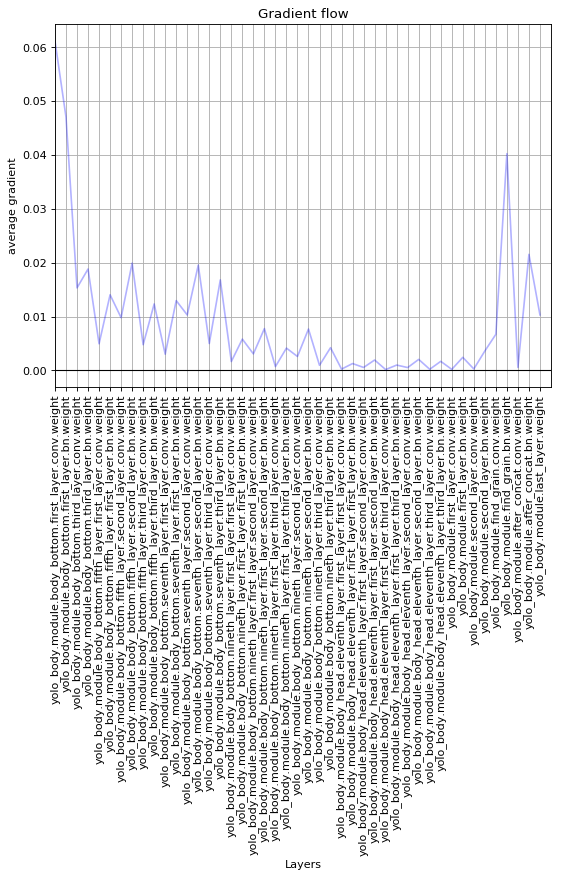

In [21]:
fig

In [22]:
print(ave_grads)

[tensor(0.0612, device='cuda:0'), tensor(0.0471, device='cuda:0'), tensor(0.0153, device='cuda:0'), tensor(0.0188, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.0140, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0199, device='cuda:0'), tensor(0.0048, device='cuda:0'), tensor(0.0123, device='cuda:0'), tensor(0.0030, device='cuda:0'), tensor(0.0130, device='cuda:0'), tensor(0.0103, device='cuda:0'), tensor(0.0196, device='cuda:0'), tensor(0.0050, device='cuda:0'), tensor(0.0168, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(0.0031, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.0077, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0042, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.